In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [63]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [10]:
transform = transforms.ToTensor()

In [11]:
training_data = datasets.MNIST(root='', download=True, train=True, transform=transform)
testing_data = datasets.MNIST(root='', download=True, train=False, transform=transform)

In [12]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
testing_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [14]:
type(training_data)

torchvision.datasets.mnist.MNIST

In [16]:
training_data[0][0].shape

torch.Size([1, 28, 28])

In [17]:
training_data[0][0].device

device(type='cpu')

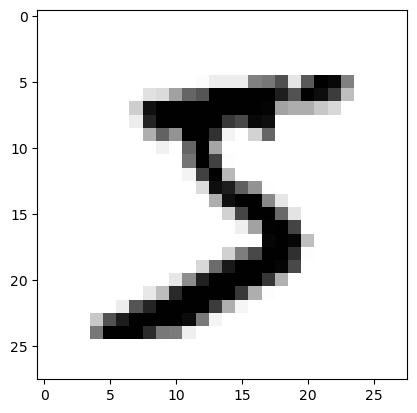

In [24]:
plt.imshow(training_data[0][0].reshape((28, 28)), cmap='gist_yarg');

In [25]:
torch.manual_seed(101)

In [101]:
train_loader = DataLoader(training_data, batch_size=100, shuffle=True, pin_memory=True)
test_loader = DataLoader(testing_data, batch_size=100, shuffle=False, pin_memory=True)

In [28]:
for images, labels in train_loader:
    break

In [29]:
images.shape

torch.Size([100, 1, 28, 28])

In [36]:
np.set_printoptions(formatter=dict(int=lambda x:f'{x:4}'))

[   4    6    2    3    4    0    9    5    0    1    6    9    5    3
    8    0    0    5    8    8]


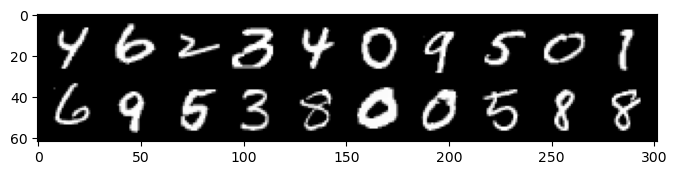

In [37]:
img = make_grid(images[:20], nrow=10)
print(labels[:20].numpy())
plt.figure(figsize=(8, 6))

plt.imshow(np.transpose(img.numpy(), (1, 2, 0)));

In [112]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_features=10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)        
        X = F.relu(self.conv2(X))        
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [115]:
model = Model()

In [116]:
model

Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [117]:
total_params = 0
for param in model.parameters():
    total_params += param.numel()
print(total_params)

60074


In [118]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [119]:
model = model.cuda()

In [120]:
start_time = time.time()

epochs = 50
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for i in range(epochs):
    print("Epoch: ", i+1, "\n==================================")
    
    trn_corr = 0
    tst_corr = 0
    for b, (x_train, y_train) in enumerate(train_loader, start=1):
        
        x_train, y_train = x_train.cuda(), y_train.cuda()
        y_hat = model(x_train)
        
        loss = criterion(y_hat, y_train)
        
        pred = torch.max(y_hat.data, 1)[1]
        batch_correct = (pred == y_train).sum()
        trn_corr += batch_correct
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if b % 200 == 0:
            print(f"  Batch: {b} | Loss:{loss.item():.3f} | Acc:{trn_corr.item()/len(train_loader):.3f}")

    train_losses.append(loss.item())
    train_accs.append(trn_corr.item()/len(train_loader))
    
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader, start=1):
            
            x_test, y_test = x_test.cuda(), y_test.cuda()
            y_hat = model(x_test)
            
            pred = torch.max(y_hat.data, 1)[1]
            tst_corr += (pred == y_test).sum()
            
        loss = criterion(y_hat, y_test)
        test_losses.append(loss.item())
        test_accs.append(tst_corr.item()/len(test_loader))
    
        
    
end_time = time.time() - start_time
print('Total time is: ', end_time/60, 'mins')

Epoch:  1 
  Batch: 200 | Loss:0.192 | Acc:24.217
  Batch: 400 | Loss:0.113 | Acc:54.852
  Batch: 600 | Loss:0.149 | Acc:86.337
Epoch:  2 
  Batch: 200 | Loss:0.076 | Acc:31.798
  Batch: 400 | Loss:0.160 | Acc:63.937
  Batch: 600 | Loss:0.078 | Acc:96.255
Epoch:  3 
  Batch: 200 | Loss:0.076 | Acc:32.348
  Batch: 400 | Loss:0.024 | Acc:64.853
  Batch: 600 | Loss:0.101 | Acc:97.457
Epoch:  4 
  Batch: 200 | Loss:0.211 | Acc:32.620
  Batch: 400 | Loss:0.085 | Acc:65.318
  Batch: 600 | Loss:0.103 | Acc:97.947
Epoch:  5 
  Batch: 200 | Loss:0.012 | Acc:32.787
  Batch: 400 | Loss:0.080 | Acc:65.570
  Batch: 600 | Loss:0.029 | Acc:98.407
Epoch:  6 
  Batch: 200 | Loss:0.003 | Acc:32.860
  Batch: 400 | Loss:0.006 | Acc:65.717
  Batch: 600 | Loss:0.010 | Acc:98.628
Epoch:  7 
  Batch: 200 | Loss:0.012 | Acc:32.975
  Batch: 400 | Loss:0.025 | Acc:65.915
  Batch: 600 | Loss:0.045 | Acc:98.883
Epoch:  8 
  Batch: 200 | Loss:0.048 | Acc:32.980
  Batch: 400 | Loss:0.017 | Acc:65.978
  Batch: 600 | 

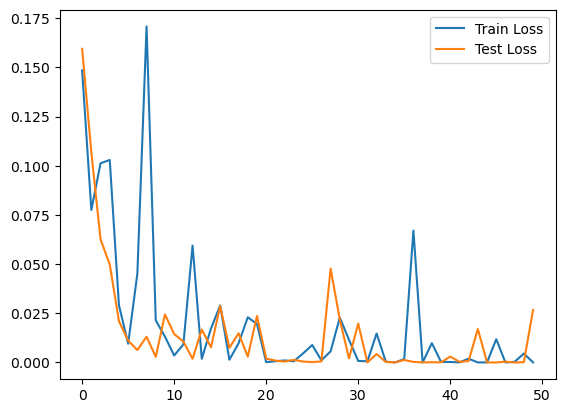

In [121]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

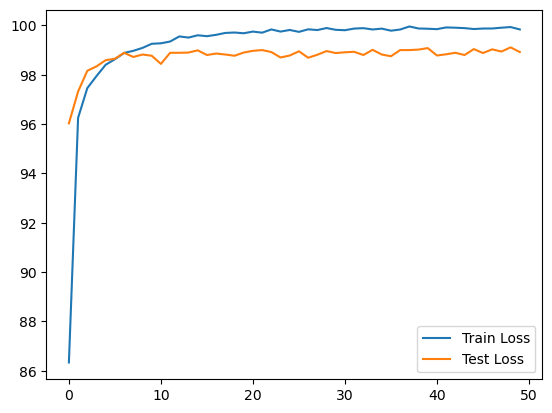

In [122]:
plt.plot(train_accs, label='Train Loss')
plt.plot(test_accs, label='Test Loss')
plt.legend()

In [109]:
len(test_loader)

100

In [110]:
test_accs

[96.73, 97.85, 97.84, 98.35, 98.52, 98.59, 98.49, 98.53, 98.63, 98.71]

In [111]:
train_accs

[88.69166666666666,
 96.955,
 97.875,
 98.26,
 98.49,
 98.7,
 98.82833333333333,
 99.02,
 99.085,
 99.16833333333334]

In [97]:
len(test_loader)

20

In [98]:
tst_corr

tensor(9887, device='cuda:0')

In [99]:
trn_corr

tensor(59585, device='cuda:0')

In [100]:
len(train_loader)

600

In [ ]:
max()